### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [323]:
import pandas as pd

# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [324]:
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


In [325]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0
...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0


### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [326]:
from zeep import Client
import pandas as pd
from datetime import datetime, timedelta
import json

# URL для SOAP API
wsdl_url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL"

# Создаём клиент SOAP
client = Client(wsdl=wsdl_url)

# Задаём диапазон дат
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)

# Делаем запрос к сервису
response = client.service.KeyRate(fromDate=start_date, ToDate=end_date)

# Извлекаем данные из вложенной структуры
key_rates = [
    {
        "date": item["KR"]["DT"],
        "key_rate": float(item["KR"]["Rate"])  # Преобразуем Decimal в float
    }
    for item in response["_value_1"]["_value_1"]
]

# Преобразуем в DataFrame
key_rates_df = pd.DataFrame(key_rates)

# Сортируем по дате
key_rates_df.sort_values("date", inplace=True)

Forcing soap:address location to HTTPS
Forcing soap:address location to HTTPS


Подготовка к слиянию транзакций и ключевой ставки

In [327]:
key_rates_df['date'] = pd.to_datetime(key_rates_df['date'], format='%Y-%m-%d', utc=True).dt.date

In [328]:
# Устанавливаем 'date' как индекс
key_rates_df.set_index('date', inplace=True)

# Создаём полный диапазон дат от минимальной до максимальной даты
full_date_range = pd.date_range(start=start_date, end=end_date)

# Reindex DataFrame для добавления пропущенных дат
key_rates_df = key_rates_df.reindex(full_date_range)

# Заполняем пропущенные значения методом bfill
key_rates_df['key_rate'] = key_rates_df['key_rate'].fillna(method='bfill')

# Сбрасываем индекс обратно в столбец
key_rates_df = key_rates_df.reset_index()
key_rates_df.rename(columns={'index': 'date'}, inplace=True)
key_rates_df['date'] = pd.to_datetime(key_rates_df['date'], format='%Y-%m-%d', utc=True).dt.date

In [329]:
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d', utc=True).dt.date

In [330]:
transactions.shape[0]

1176

In [331]:
# кладём ключевую ставку в transactions
transactions = transactions.merge(key_rates_df, on='date', how='left')

In [332]:
transactions.shape[0]

1176

In [333]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0
1,2024-01-12,ATM_2,0.0,0.0,0.0,16.0
2,2024-01-12,ATM_3,0.0,0.0,0.0,16.0
3,2024-01-12,ATM_4,0.0,0.0,0.0,16.0
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0
1172,2024-10-31,ATM_1,3215500.0,0.0,171600.0,21.0
1173,2024-10-31,ATM_2,4754600.0,0.0,395100.0,21.0
1174,2024-10-31,ATM_3,2277000.0,0.0,1000.0,21.0


Баланс для начала дня

In [334]:
import pandas as pd

# Функция для расчета баланса на начало дня
def calc_bal_beg_of_day(row, prev_row):
    if pd.notna(prev_row):  # Проверяем, есть ли предыдущая строка
        beg_bal = row['bal_end_of_day'] + row['cash_out']
        if row['cash_in'] != 0:
            beg_bal = prev_row['bal_end_of_day']  # Используем значение из предыдущей строки
        return beg_bal
    else:
        # Если это первая строка для ATM_ID, возвращаем начальное значение баланса
        return row['bal_end_of_day'] + row['cash_out']

# Создаем функцию, которая будет применяться к каждой группе ATM_ID
def apply_calc_group(group):
    # Создаем сдвинутую версию таблицы, где для каждой строки сохраняются данные предыдущей строки
    group['prev_row'] = group.shift(1).to_dict('records')
    
    # Применяем расчет для каждого дня в группе
    group['bal_beg_of_day'] = group.apply(
        lambda row: calc_bal_beg_of_day(row, row['prev_row']), axis=1
    )
    return group

# Применяем функцию к данным
transactions = transactions.groupby('ATM_ID').apply(apply_calc_group)
transactions = transactions.reset_index(drop=True)

# Сброс
transactions = transactions.drop('prev_row', axis=1)
# Просмотр результатов
transactions[['date', 'ATM_ID', 'bal_beg_of_day']]

,date,ATM_ID,bal_beg_of_day
0,2024-01-12,ATM_1,0.0
1,2024-01-13,ATM_1,0.0
2,2024-01-14,ATM_1,0.0
3,2024-01-15,ATM_1,0.0
4,2024-01-16,ATM_1,0.0
...,...,...,...
1171,2024-10-27,ATM_4,752650.0
1172,2024-10-28,ATM_4,752650.0
1173,2024-10-29,ATM_4,752650.0
1174,2024-10-30,ATM_4,748650.0


Считаем упущенный доход

Формула для расчёта упущенного процентного дохода основывается на предположении, что банк мог бы вложить свои деньги под ставку, равную ключевой ставке Центрального Банка. Ключевая ставка ЦБ указывается в процентах годовых. Нам нужно вычислить доход, который был бы получен за один день.

In [335]:
transactions['missed_income'] = transactions['bal_end_of_day'] * (transactions['key_rate'] / (100 * 365))

In [336]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,bal_beg_of_day,missed_income
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000
1,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000
2,2024-01-14,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000
3,2024-01-15,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000
4,2024-01-16,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
1171,2024-10-27,ATM_4,752650.0,0.0,0.0,21.0,752650.0,433.031507
1172,2024-10-28,ATM_4,752650.0,0.0,0.0,21.0,752650.0,433.031507
1173,2024-10-29,ATM_4,748650.0,0.0,4000.0,21.0,752650.0,430.730137
1174,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,748650.0,430.154795


### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [337]:
# заполним NULL поля
fees.fillna(0, inplace=True)

In [338]:
len(transactions)

1176

In [339]:
# вставляем fees в transactions
transactions = transactions.merge(fees, on='ATM_ID', how='left')

In [340]:
len(transactions)

1176

Считаем стоимость инкассации

In [341]:
import numpy as np

transactions['cash_delivery'] = np.where(
    transactions['cash_in'] == 0,
    0,
    transactions['CashDeliveryFixedFee'] + np.maximum(
        transactions['CashDeliveryPercentageFee'] * transactions['cash_in'],
        transactions['CashDeliveryMinFee']
    ) 
)

transactions['cash_collection'] = np.where(
    transactions['cash_in'] == 0,
    0,
    transactions['CashCollectionFixedFee'] + np.maximum(
        transactions['CashCollectionPercentageFee'] * transactions['bal_beg_of_day'],
        transactions['CashCollectionMinFee']
    ) 
)

transactions['incassation_cost'] = transactions['cash_delivery'] + transactions['cash_collection']

In [342]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,bal_beg_of_day,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,cash_delivery,cash_collection,incassation_cost
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
2,2024-01-14,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
3,2024-01-15,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
4,2024-01-16,ATM_1,0.0,0.0,0.0,16.0,0.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,2024-10-27,ATM_4,752650.0,0.0,0.0,21.0,752650.0,433.031507,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0.0,0.0,0.0
1172,2024-10-28,ATM_4,752650.0,0.0,0.0,21.0,752650.0,433.031507,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0.0,0.0,0.0
1173,2024-10-29,ATM_4,748650.0,0.0,4000.0,21.0,752650.0,430.730137,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0.0,0.0,0.0
1174,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,748650.0,430.154795,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0.0,0.0,0.0


### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

In [343]:
# Описание данных
print("Общая информация о данных:")
print(transactions.info())
print()
print("Основные статистики:")
print(transactions.describe())

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         1176 non-null   object 
 1   ATM_ID                       1176 non-null   string 
 2   bal_end_of_day               1176 non-null   float64
 3   cash_in                      1176 non-null   float64
 4   cash_out                     1176 non-null   float64
 5   key_rate                     1176 non-null   float64
 6   bal_beg_of_day               1176 non-null   float64
 7   missed_income                1176 non-null   float64
 8   CashDeliveryFixedFee         1176 non-null   float64
 9   CashDeliveryPercentageFee    1176 non-null   float64
 10  CashDeliveryMinFee           1176 non-null   float64
 11  CashCollectionFixedFee       1176 non-null   float64
 12  CashCollectionPercentageFee  1176 non-null   floa

In [344]:
# Группировка по банкоматам
grouped_by_atm = transactions.groupby('ATM_ID').agg({
    'bal_end_of_day': ['mean', 'min', 'max', 'std', 'sum', 'count'],
    'cash_out': ['mean', 'min', 'max', 'std', 'sum', 'count'],
    'cash_in': ['mean', 'min', 'max', 'std', 'sum', 'count'],
    'incassation_cost': ['mean', 'min', 'max', 'std', 'sum', 'count'],
    'missed_income': ['mean', 'min', 'max', 'std', 'sum', 'count']
}).reset_index()
print()
print("Группированные данные по банкоматам:")
print(grouped_by_atm)


Группированные данные по банкоматам:
  ATM_ID bal_end_of_day                                                    \
                   mean  min        max           std           sum count   
0  ATM_1   3.666365e+06  0.0  6545500.0  1.767245e+06  1.077911e+09   294   
1  ATM_2   3.999686e+06  0.0  7119900.0  1.766966e+06  1.175908e+09   294   
2  ATM_3   2.776978e+06  0.0  5925000.0  1.735360e+06  8.164316e+08   294   
3  ATM_4   1.074001e+06  0.0  1630000.0  3.691588e+05  3.157562e+08   294   

        cash_out                  ... incassation_cost                         \
            mean  min        max  ...              max         std        sum   
0  390943.877551  0.0  1594200.0  ...          2027.00  532.814929  44474.000   
1  391734.693878  0.0  1909800.0  ...          2077.00  541.628603  45204.000   
2   58422.789116  0.0   623200.0  ...          2925.00  378.836939  14625.000   
3    8677.210884  0.0   127250.0  ...         11930.65  903.704801  26019.675   

        miss

In [345]:
from IPython.core.display import HTML
print('bal_end_of_day')
display(HTML(grouped_by_atm['bal_end_of_day'].to_html()))

print('cash_out')
display(HTML(grouped_by_atm['cash_out'].to_html()))

print('cash_in')
display(HTML(grouped_by_atm['cash_in'].to_html()))

print('incassation_cost')
display(HTML(grouped_by_atm['incassation_cost'].to_html()))

print('missed_income')
display(HTML(grouped_by_atm['missed_income'].to_html()))

bal_end_of_day


,mean,min,max,std,sum,count
0,3.666365e+06,0.0,6545500.0,1.767245e+06,1.077911e+09,294
1,3.999686e+06,0.0,7119900.0,1.766966e+06,1.175908e+09,294
2,2.776978e+06,0.0,5925000.0,1.735360e+06,8.164316e+08,294
3,1.074001e+06,0.0,1630000.0,3.691588e+05,3.157562e+08,294


cash_out


,mean,min,max,std,sum,count
0,390943.877551,0.0,1594200.0,344635.680836,114937500.0,294
1,391734.693878,0.0,1909800.0,389629.884525,115170000.0,294
2,58422.789116,0.0,623200.0,84941.266544,17176300.0,294
3,8677.210884,0.0,127250.0,17250.819075,2551100.0,294


cash_in


,mean,min,max,std,sum,count
0,491292.517007,0.0,6620000.0,1.730598e+06,144440000.0,294
1,516122.448980,0.0,7120000.0,1.820076e+06,151740000.0,294
2,79455.782313,0.0,5980000.0,6.322475e+05,23360000.0,294
3,16632.653061,0.0,1630000.0,1.640919e+05,4890000.0,294


incassation_cost


,mean,min,max,std,sum,count
0,151.272109,0.0,2027.00,532.814929,44474.000,294
1,153.755102,0.0,2077.00,541.628603,45204.000,294
2,49.744898,0.0,2925.00,378.836939,14625.000,294
3,88.502296,0.0,11930.65,903.704801,26019.675,294


missed_income


,mean,min,max,std,sum,count
0,1693.366359,0.0,3248.583562,821.953592,497849.709589,294
1,1844.362110,0.0,3408.328767,818.327089,542242.460274,294
2,1262.546231,0.0,2597.260274,753.747711,371188.591781,294
3,493.449935,0.0,714.520548,158.294268,145074.280822,294


In [346]:
# Определяем пороги
cash_out_threshold = grouped_by_atm['cash_out']['mean'].quantile(0.75)
cash_out_count_median = grouped_by_atm['cash_out']['count'].median()
cash_in_count_median = grouped_by_atm['cash_in']['count'].median()

# Классификация банкоматов
grouped_by_atm['type'] = 'Другие'
grouped_by_atm.loc[
    (grouped_by_atm['cash_out']['mean'] > cash_out_threshold) &
    (grouped_by_atm['cash_out']['count'] > cash_out_count_median),
    'type'
] = 'Часто используемые'

grouped_by_atm.loc[
    (grouped_by_atm['cash_out']['mean'] > cash_out_threshold) &
    (grouped_by_atm['cash_out']['count'] <= cash_out_count_median),
    'type'
] = 'Редкие, крупные снятия'

grouped_by_atm.loc[
    (grouped_by_atm['cash_in']['count'] > cash_in_count_median),
    'type'
] = 'Частые инкассации'

print()
print("Классификация банкоматов:")
print(grouped_by_atm[['ATM_ID', 'type']])


Классификация банкоматов:
  ATM_ID                    type
                                
0  ATM_1                  Другие
1  ATM_2  Редкие, крупные снятия
2  ATM_3                  Другие
3  ATM_4                  Другие


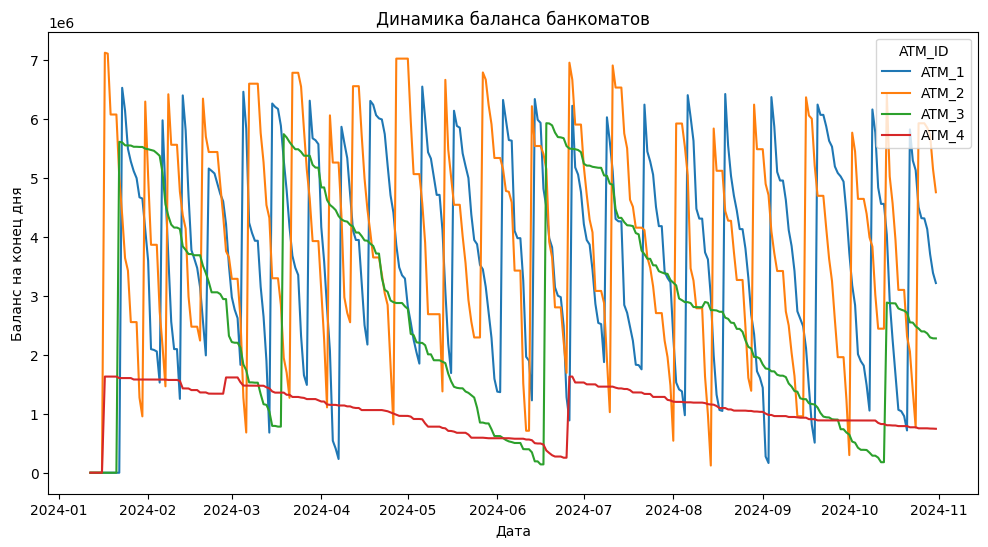

In [347]:
import matplotlib.pyplot as plt
import seaborn as sns

# Временные ряды для каждого банкомата
plt.figure(figsize=(12, 6))
sns.lineplot(data=transactions, x='date', y='bal_end_of_day', hue='ATM_ID')
plt.title('Динамика баланса банкоматов')
plt.xlabel('Дата')
plt.ylabel('Баланс на конец дня')
plt.legend(title='ATM_ID', loc='upper right')
plt.show()

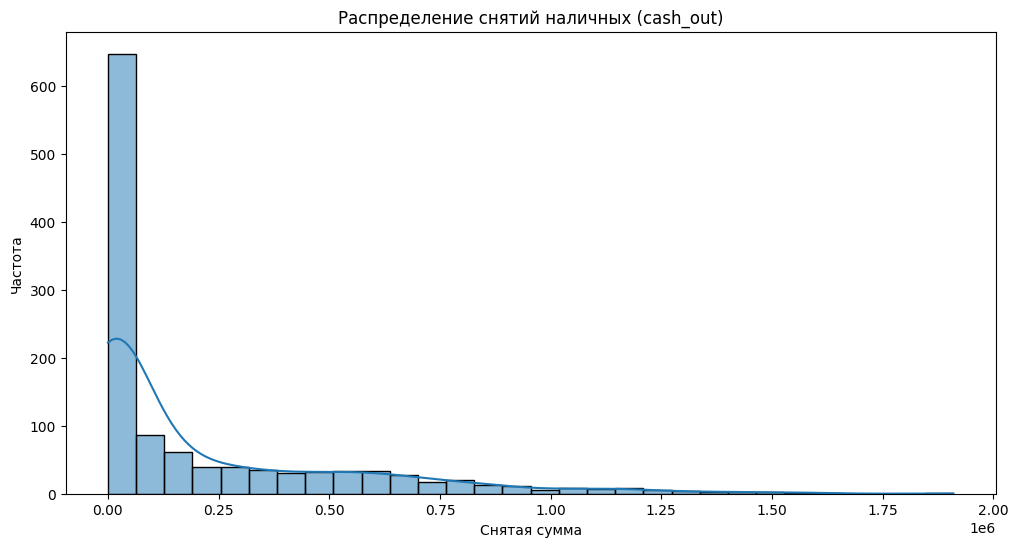

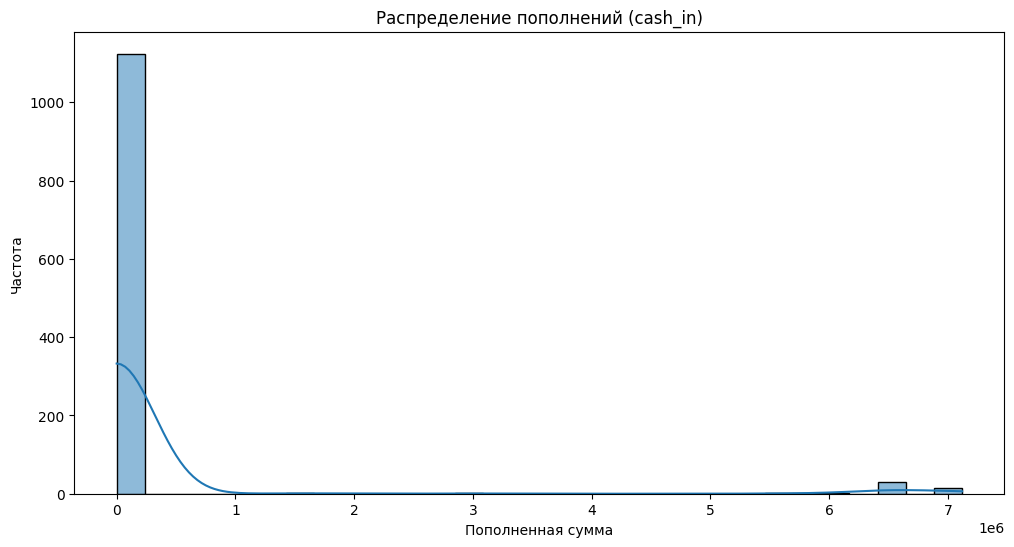

In [348]:
# Распределение снятий
plt.figure(figsize=(12, 6))
sns.histplot(transactions['cash_out'], bins=30, kde=True)
plt.title('Распределение снятий наличных (cash_out)')
plt.xlabel('Снятая сумма')
plt.ylabel('Частота')
plt.show()

# Распределение пополнений
plt.figure(figsize=(12, 6))
sns.histplot(transactions['cash_in'], bins=30, kde=True)
plt.title('Распределение пополнений (cash_in)')
plt.xlabel('Пополненная сумма')
plt.ylabel('Частота')
plt.show()

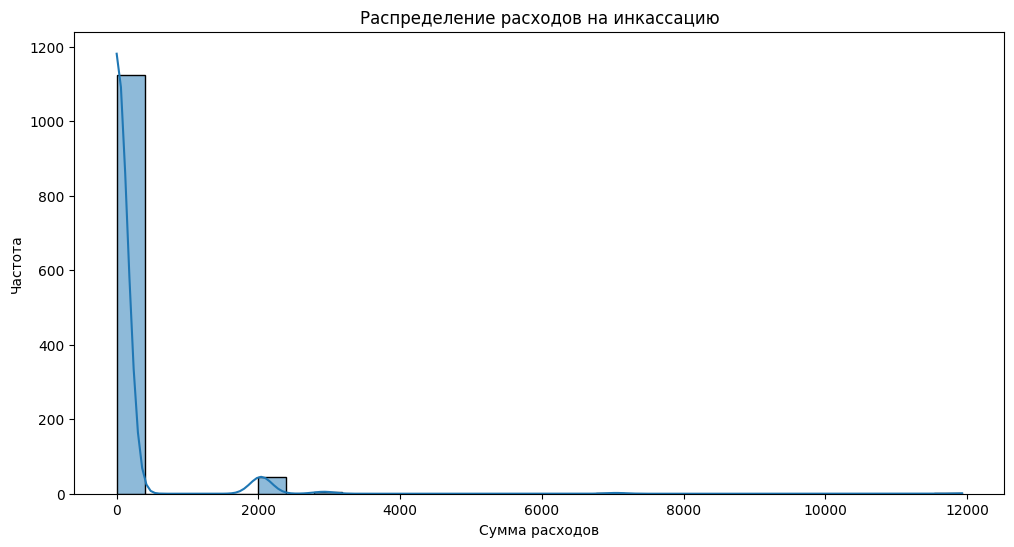

In [349]:
# Распределение расходов на инкассацию
plt.figure(figsize=(12, 6))
sns.histplot(transactions['incassation_cost'], bins=30, kde=True)
plt.title('Распределение расходов на инкассацию')
plt.xlabel('Сумма расходов')
plt.ylabel('Частота')
plt.show()

### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


Представьте, что итог вашей работы состоит из 2 частей:
1) Вы презентуете своё решение руководителям банка. В этой части вы показываете, как ваше решение экономит деньги. Вы можете показать сценарий с Service Level 90% как базовый и сравнить, сколько мы сэкономим денег, если снизим его до 80% или увеличим до 95%.
2) Вы презентуете свою систему для исполнителей, а им нужно понимать за 3 дня до доставки кассеты, какую сумму заказывать, какой баланс у банкомата в какие даты должен быть. Возможно, решите ещё что-то им предоставить из данных, чтобы исполнители эффективно реализовали вашу задумку.


С использованием машинного обучения

Пробуем модель SARIMAX на банкомате 1

Все даты до октября идут в train_data, октябрь идёт в test_data

In [350]:
atm_1_df = transactions[transactions['ATM_ID'] == 'ATM_1'].copy()

train_data = atm_1_df[atm_1_df['date'] < datetime(2024, 10, 1).date()]  
test_data = atm_1_df[atm_1_df['date'] >= datetime(2024, 10, 1).date()] 

train_data = train_data[['date', 'cash_out']]
train_data = train_data.set_index('date')

test_data = test_data[['date', 'cash_out']]
test_data = test_data.set_index('date')


Стационарный ли процесс

In [351]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train_data['cash_out'])
print('p-value = ' + str(adf_test[1]))

if adf_test[1] > 0.05:
    print('it is not a stationary process')
else:
    print('it is a stationary process')

p-value = 0.00016498546222334912
it is a stationary process


In [352]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(train_data['cash_out'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42033D+01    |proj g|=  2.17600D-01


 This problem is unconstrained.



At iterate    5    f=  1.41284D+01    |proj g|=  3.97196D-02

At iterate   10    f=  1.41250D+01    |proj g|=  4.99205D-03

At iterate   15    f=  1.41237D+01    |proj g|=  4.06560D-03

At iterate   20    f=  1.41219D+01    |proj g|=  1.80593D-02

At iterate   25    f=  1.41196D+01    |proj g|=  7.88744D-04

At iterate   30    f=  1.41195D+01    |proj g|=  2.94626D-03

At iterate   35    f=  1.41192D+01    |proj g|=  5.71430D-03

At iterate   40    f=  1.41191D+01    |proj g|=  2.68902D-03

At iterate   45    f=  1.41189D+01    |proj g|=  7.53439D-03

At iterate   50    f=  1.41185D+01    |proj g|=  8.55512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [353]:
arima_pred = arima_result.predict(start = len(train_data), end = len(train_data) + 30, typ="levels").rename("ARIMA Predictions")
arima_pred

2024-10-01    334711.729757
2024-10-02    136520.640688
2024-10-03    168612.907928
2024-10-04    327365.255093
2024-10-05    313175.793324
2024-10-06    315696.621429
2024-10-07    259820.123520
2024-10-08    338452.401908
2024-10-09    213480.249497
2024-10-10    286230.999121
2024-10-11    297957.520533
2024-10-12    213647.373599
2024-10-13    194309.452182
2024-10-14    279083.747030
2024-10-15    328943.083102
2024-10-16    266923.928391
2024-10-17    167494.035183
2024-10-18    338544.583591
2024-10-19    282459.442694
2024-10-20    132085.658122
2024-10-21    290312.168180
2024-10-22    414203.773692
2024-10-23    227367.633324
2024-10-24    256351.380482
2024-10-25    303589.432873
2024-10-26    272883.353383
2024-10-27    156064.335068
2024-10-28    277216.233569
2024-10-29    371827.500129
2024-10-30    321195.556957
2024-10-31    142748.457817
Freq: D, Name: ARIMA Predictions, dtype: float64

In [354]:
global_test_data = test_data.copy()
global_test_data['ARIMA_Predictions'] = arima_pred

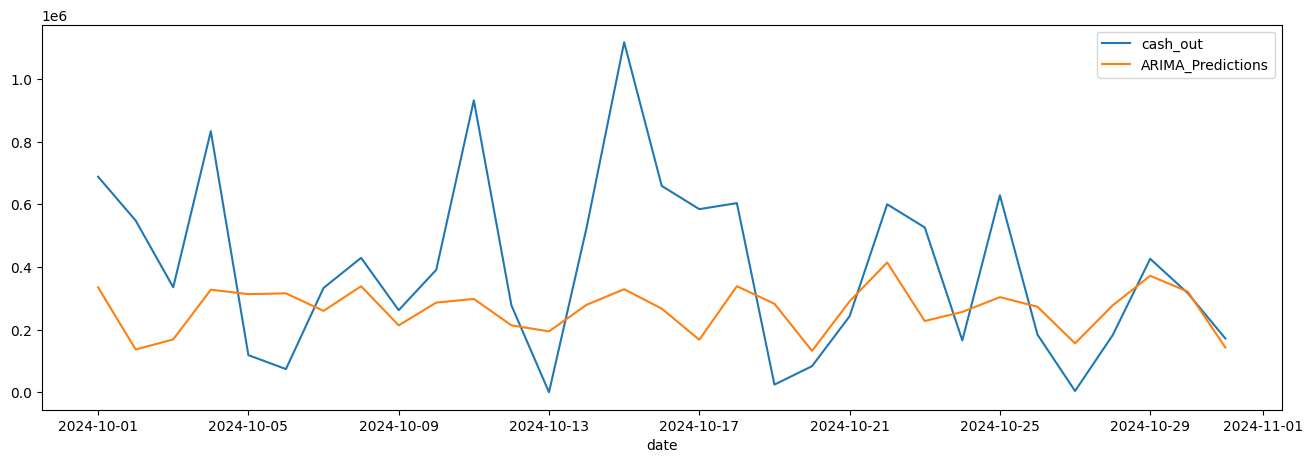

In [355]:
global_test_data['cash_out'].plot(figsize = (16,5), legend=True)
global_test_data['ARIMA_Predictions'].plot(legend = True);

In [356]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['cash_out'], arima_pred)

print(f'RMSE Error: {arima_rmse_error}\n')

RMSE Error: 288484.50545712217



Теперь применим RNN и сравним с SARIMAX

In [357]:
train_data.shape

(263, 1)

Скейлим данные

In [358]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Подготавливаем к обучению

In [359]:
from keras.preprocessing.sequence import TimeseriesGenerator


n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

Задаём модель

In [360]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot  as plt


rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[n_input, n_features]),
    tf.keras.layers.LSTM(150, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')

rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 12, 128)           512       
                                                                 
 lstm_8 (LSTM)               (None, 12, 150)           167400    
                                                                 
 lstm_9 (LSTM)               (None, 50)                40200     
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 210,713
Trainable params: 210,713
Non-trainable params: 0
_________________________________________________________________


Обучаемся

In [361]:
rnn_model.fit_generator(generator, epochs=25)

Epoch 1/25
251/251 [==============================] - 5s 8ms/step - loss: 0.0543
Epoch 2/25
251/251 [==============================] - 2s 8ms/step - loss: 0.0519
Epoch 3/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0495
Epoch 4/25
251/251 [==============================] - 2s 8ms/step - loss: 0.0496
Epoch 5/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0478
Epoch 6/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0493
Epoch 7/25
251/251 [==============================] - 2s 8ms/step - loss: 0.0464
Epoch 8/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0457
Epoch 9/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0458
Epoch 10/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0432
Epoch 11/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0446
Epoch 12/25
251/251 [==============================] - 2s 7ms/step - loss: 0.0443
Epoch 13/25
251/251 [====

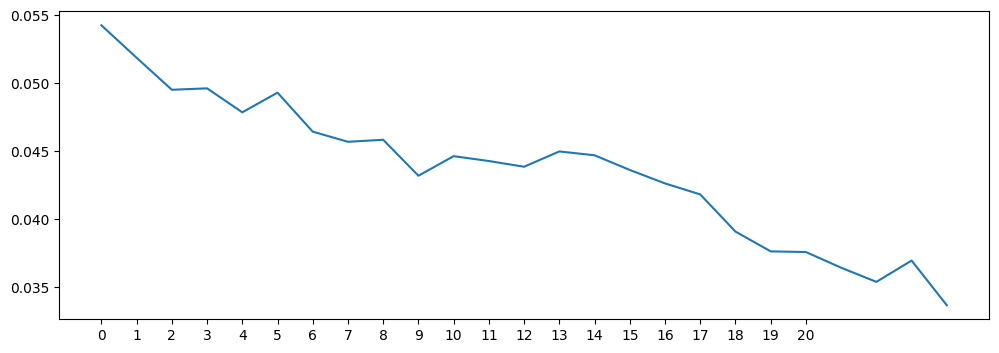

In [362]:
losses_rnn = rnn_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_rnn)),losses_rnn);

In [363]:
RNN_Predictions_scaled = list()

batch = scaled_train_data[-n_input:]
print('batch')
print(batch)
print('shape is ', batch.shape)
# shape is (1, 12, 1)
current_batch = batch.reshape((1, n_input, n_features))
print('current batch')
print(current_batch)
print('shape is ', current_batch.shape)
for i in range(len(test_data)):   
    rnn_pred = rnn_model.predict(current_batch)[0]
    RNN_Predictions_scaled.append(rnn_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[rnn_pred]],axis=1)
    print('current_batch now\n', current_batch)
    print('current_batch shape\n', current_batch.shape)

batch
[[0.18975035]
 [0.1124702 ]
 [0.10927111]
 [0.        ]
 [0.12288295]
 [0.15305482]
 [0.0622883 ]
 [0.21076402]
 [0.06925104]
 [0.03638188]
 [0.05507465]
 [0.32743696]]
shape is  (12, 1)
current batch
[[[0.18975035]
  [0.1124702 ]
  [0.10927111]
  [0.        ]
  [0.12288295]
  [0.15305482]
  [0.0622883 ]
  [0.21076402]
  [0.06925104]
  [0.03638188]
  [0.05507465]
  [0.32743696]]]
shape is  (1, 12, 1)
1/1 [==============================] - 1s 533ms/step
current_batch now
 [[[0.1124702 ]
  [0.10927111]
  [0.        ]
  [0.12288295]
  [0.15305482]
  [0.0622883 ]
  [0.21076402]
  [0.06925104]
  [0.03638188]
  [0.05507465]
  [0.32743696]
  [0.33233672]]]
current_batch shape
 (1, 12, 1)
1/1 [==============================] - 0s 18ms/step
current_batch now
 [[[0.10927111]
  [0.        ]
  [0.12288295]
  [0.15305482]
  [0.0622883 ]
  [0.21076402]
  [0.06925104]
  [0.03638188]
  [0.05507465]
  [0.32743696]
  [0.33233672]
  [0.27245742]]]
current_batch shape
 (1, 12, 1)
1/1 [==============

In [364]:
RNN_Predictions = scaler.inverse_transform(RNN_Predictions_scaled)

In [365]:
global_test_data['RNN_Predictions'] = RNN_Predictions

Смотрим на результат

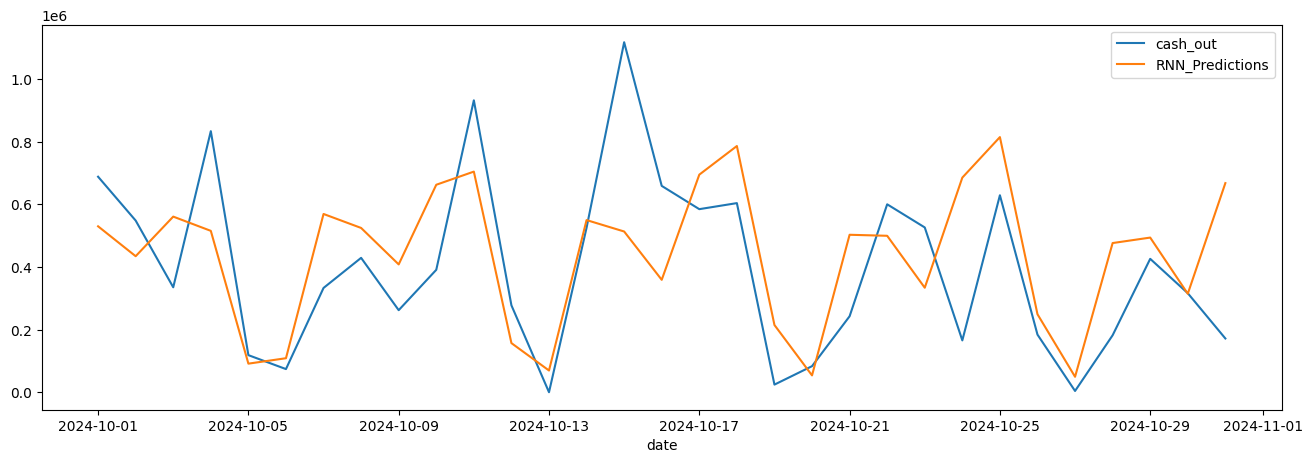

In [366]:
global_test_data['cash_out'].plot(figsize = (16,5), legend=True)
global_test_data['RNN_Predictions'].plot(legend = True);

In [367]:
rnn_rmse_error = rmse(global_test_data['cash_out'], global_test_data["RNN_Predictions"])

print(f'RMSE Error: {rnn_rmse_error}\n')

RMSE Error: 235917.29439441656



Сравнием ARIMA (SARIMAX) и RNN

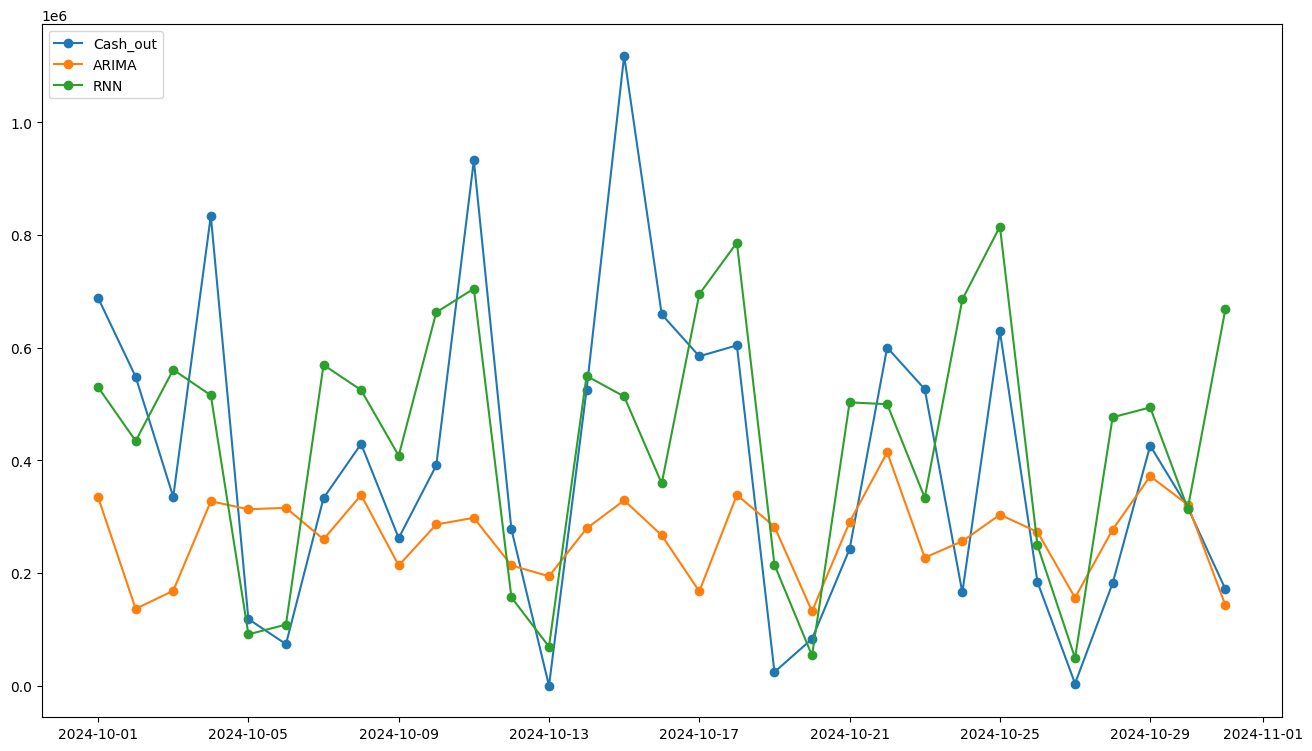

In [368]:
plt.figure(figsize=(16,9))
plt.plot_date(global_test_data.index, global_test_data["cash_out"], linestyle="-")
plt.plot_date(global_test_data.index, global_test_data["ARIMA_Predictions"], linestyle="-")
plt.plot_date(global_test_data.index, global_test_data["RNN_Predictions"], linestyle="-")
plt.legend(["Cash_out", "ARIMA", 'RNN'], loc ="upper left")
plt.show()

RNN справилась с прогнозом лучше

In [369]:
start_date = datetime(2024, 10, 1).date()
end_date = datetime(2024, 10, 31).date()

amt_1_oct_df = transactions[(transactions['date'] >= start_date) & (transactions['date'] <= end_date)][transactions['ATM_ID'] == 'ATM_1']
amt_1_oct_df

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,bal_beg_of_day,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,cash_delivery,cash_collection,incassation_cost
263,2024-10-01,ATM_1,3724900.0,0.0,688200.0,19.0,4413100.0,1938.989041,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,2024-10-02,ATM_1,3176700.0,0.0,548200.0,19.0,3724900.0,1653.624658,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,2024-10-03,ATM_1,2841600.0,0.0,335100.0,19.0,3176700.0,1479.189041,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,2024-10-04,ATM_1,2007900.0,0.0,833700.0,19.0,2841600.0,1045.208219,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,2024-10-05,ATM_1,1889500.0,0.0,118400.0,19.0,2007900.0,983.575342,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,2024-10-06,ATM_1,1815600.0,0.0,73900.0,19.0,1889500.0,945.106849,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,2024-10-07,ATM_1,1482600.0,0.0,333000.0,19.0,1815600.0,771.764384,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,2024-10-08,ATM_1,1053500.0,0.0,429100.0,19.0,1482600.0,548.397260,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271,2024-10-09,ATM_1,6158000.0,6420000.0,262000.0,19.0,1053500.0,3205.534247,1365.0,0.0001,0.0,0.0,0.0,0.0,2007.0,0.0,2007.0
272,2024-10-10,ATM_1,5767100.0,0.0,390900.0,19.0,6158000.0,3002.052055,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
amt_1_oct_df['rnn_pred'] = RNN_Predictions
amt_1_oct_df['rnn_pred'] = np.where(amt_1_oct_df['rnn_pred'] < 0, 5000, amt_1_oct_df['rnn_pred'])

In [371]:
amt_1_oct_df[['bal_beg_of_day', 'bal_end_of_day', 'cash_out', 'cash_in', 'rnn_pred']]

,bal_beg_of_day,bal_end_of_day,cash_out,cash_in,rnn_pred
263,4413100.0,3724900.0,688200.0,0.0,529811.205089
264,3724900.0,3176700.0,548200.0,0.0,434351.620281
265,3176700.0,2841600.0,335100.0,0.0,560798.454666
266,2841600.0,2007900.0,833700.0,0.0,515317.731464
267,2007900.0,1889500.0,118400.0,0.0,91253.590697
268,1889500.0,1815600.0,73900.0,0.0,108574.364474
269,1815600.0,1482600.0,333000.0,0.0,569221.465409
270,1482600.0,1053500.0,429100.0,0.0,524590.806556
271,1053500.0,6158000.0,262000.0,6420000.0,408174.560452
272,6158000.0,5767100.0,390900.0,0.0,662519.210958


Далее необходимо делать опмитизацию месяца с учетом предсказаний RNN